# `Материалы кафедры ММП факультета ВМК МГУ. Введение в глубокое обучение.`

# `Занятие 05. Оптимизация в глубоком обучении`

## `Занятие провел: Феоктистов Дмитрий (@trandelik)`

## `Материалы составили: Феоктистов Дмитрий (@trandelik), Находнов Максим (nakhodnov17@gmail.com)`

### `Москва, Весенний семестр 2026`

Источники:

- [1] **RMSProp**: [Geoffrey Hinton, 2012](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf), примерно 2.5 тысячи цитирований
- [2] **AdaGrad**: [Duchi et al., 2011](https://jmlr.org/papers/volume12/duchi11a/duchi11a.pdf), примерно 16 тысяч цитирований
- [3] **Adam**: [Kingma & Ba, 2014](https://arxiv.org/pdf/1412.6980), примерно 240 тысяч цитирований
- [4] О неоптимальности глобального минимума: [Qingguang Guan](https://arxiv.org/abs/2407.16872v1), 1 цитирование
- [5] Усреденение весов приводит к более широкому минимуму: [Izmailov et al., 2018](https://arxiv.org/pdf/1803.05407), примерно 2 тысячи цитирований
- [6] О больших learning rate: [Lobacheva et al., 2023](https://arxiv.org/pdf/2311.11303), 4 цитирования
- [7] О больших learning rate: [Sadrtdinov et al., 2024](https://arxiv.org/abs/2410.22113), 6 цитирований
- [8] learing rate warmup и самостабилизация обучения: [Kalra & Barkeshli, 2024](https://arxiv.org/pdf/2406.09405), 69 цитирований
- [9] learning rate warmup и обобщенная гладкость: [Riabinin et al., 2026](https://arxiv.org/pdf/2602.05813), пока без цитирований
- [10] **AdamW**: [Loshchilov & Hutter, 2017](https://arxiv.org/abs/1711.05101), примерно 38 тысяч цитирований
- [11] **AdEMAMix**: [Pagliardini et al., 2024](https://arxiv.org/abs/2409.03137), 31 цитирование
- [12] **warmup-stable-decay scheduler**: [Hägele et al., 2024](https://arxiv.org/abs/2405.18392), 101 цитирование
- [13] **Schedule-Free Optimizer** ([[Defazio et al., 2024]](https://arxiv.org/abs/2405.15682)), 146 цитирований
- [14] **SignSGD** и **Signum**: [Bernstein et al., 2019](https://arxiv.org/abs/1802.04434), примерно 1.5 тысячи цитирований
- [15] **Lion**: [Chen et al., 2023](https://arxiv.org/abs/2302.06675), 810 цитирований
- [16] **Shampoo**: [Gupta et al., 2018](https://arxiv.org/abs/1802.09568), 430 цитирований
- [17] **SOAP**: [Vyas et al., 2024](https://arxiv.org/abs/2409.11321), 148 цитирований
- [18] **Muon**: [Jordan et al., 2024](https://kellerjordan.github.io/posts/muon/), 214 цитирований

О чём можно узнать из этого ноутбука:

* Базовые методы оптимизации в DL
* Learning Rate Schedulers и зачем это нужно
* Современные результаты в оптимизации

---

## Обучение нейросетей

Как было разобрано в предыдущих лекциях, при некоторых условиях (на функцию активации и ширину сетей) класс функций, задаваемых MLP, очень широк (все возможные непрерывные на компакте функции). Однако, как обучать такие модели? Самым распространённым способом является градиентный спуск и стохастический градиентный спуск.

Положим, что наша нейронная сеть представляет собой функцию $f_{w}(x)$, где $w \in \mathbb{R}^{D}, x \in \mathbb{R}^{d}$ &ndash; тензоры параметров и признаков. Положим $D = \{(x_{i}, y_{i})\}_{1}^{n}$ &ndash; обучающая выборка. $L(\hat{y}, y)$ &ndash; функция потерь. Наша задача заключается в минимизации эмпирического риска для заданной выборки и функции потерь:
$$
\mathfrak{L} = \mathfrak{L}(w) = \mathbb{E}_{x, y \sim D}L(f_{w}(x), y) = \frac{1}{n}\sum\limits_{i=1}^{n}L(f_{w}(x_{i}), y_{i}) = \frac{1}{n}\sum\limits_{i=1}^{n}L_{i}(w) \longrightarrow \min\limits_{w}.
$$

Тогда, можно предложить итеративный алгоритм для поиска локальных минимумов функции $\mathfrak{L}$ &ndash; **градиентный спуск**:
$$
w^{i+1} = w^{i} - \epsilon_{i}\nabla_{w}\mathfrak{L}(w) = w^{i} - \epsilon_{i}\Delta^{i}.
$$

Запишем эквивалентно приращение параметров модели:
$$
\Delta^{i} = \nabla_{w}\mathfrak{L}(w) = \frac{1}{n}\sum\limits_{j=1}^{n}\nabla_{w}L_{j}(w). \;\; (2)
$$

Оценим сложность одной итерации такого алгоритма. Допустим, вычисление $\nabla_{w}L_{j}$ требует $\mathcal{O}(s)$ операций. Тогда вычисление по формуле $(2)$ требует $\mathcal{O}(ns)$ операций.

Однако, при работе с большими выборками ($n >> 1$), а именно такие чаще всего встречаются при работе с нейросетями, линейная зависимость времени работы от размера выборки вычислительно недопустима.

Для решения этой проблемы обычно применяется **стохастический градиентный спуск**. Основное отличие SGD от SD состоит в использовании несмещённой оценки градиента эмпирического риска:

$$
\Delta^{i} = \frac{1}{|I_{i}|}\sum\limits_{j \in I_{i}}\nabla_{w}\mathfrak{L}^{j}(w),\;\; I_{i} \sim \mathcal{U}[\mathfrak{B}]. \;\; (3)
$$
Где $\mathfrak{B}$ &ndash; множество всех возможных батчей размера $B$ без повторений элементов внутри батча.

В таком случае, сложность одной операции перестаёт зависеть от $n$: $\mathcal{O}(Bs) = \mathcal{O}(s)$ что позволяет реализовать данный алгоритм на практике.

Однако, у SGD появляются отличия по сравнению с SG:
1. Итерации $(3)$ не обязательно уменьшают $\mathfrak{L}$ даже при очень малых $\epsilon$, что с одной стороны может замедлить сходимость, но с другой стороны позволяет не застревать в локальных минимумах.
2. Сложнее определить критерий останова, так как, например, в случае с SD в точке минимума $\Delta^{i} = 0$, а для SGD это неверно.
4. Добавляется ещё один гиперпараметр, который может значительно влиять на процесс обучения.
4. Наличие дисперсии в оценке градиента может не позволить сойтись SGD при константном темпе обучения. SGD будет "сходиться" к некой области, называемой **confusion region**.
5. Выбор оптимального темпа обучения очень важен, чтобы соблюсти баланс между размером confusion region и скоростью сходимости.

In [ ]:
%matplotlib inline

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [ ]:
def get_sgd_iters(log10_epsilon=-4.0):
    # Make SGD iterations
    n_steps = 1000
    epsilon = 10.0 ** log10_epsilon
    x = torch.tensor([10.0, 10.0, 10.0])
    y = torch.tensor([-10.0, 0.0, 20.0])
    w_gd = torch.tensor([-5.0], requires_grad=True)
    w_sgd = torch.tensor([-5.0], requires_grad=True)
    weights_gd = []
    weights_sgd = []
    for step in range(n_steps):
        weights_gd.append(w_gd.item())
        weights_sgd.append(w_sgd.item())

        loss_gd = torch.sum(torch.square(x * w_gd - y))
        loss_gd.backward()

        idx = torch.randint(high=x.shape[0], size=[1])
        loss_sgd = torch.square(x[idx] * w_sgd - y[idx])
        loss_sgd.backward()

        with torch.no_grad():
            w_gd.sub_(epsilon * w_gd.grad)
            w_sgd.sub_(epsilon * w_sgd.grad)
        w_gd.grad.detach_()
        w_gd.grad.zero_()
        w_sgd.grad.detach_()
        w_sgd.grad.zero_()
    weights_gd = np.array(weights_gd)
    weights_sgd = np.array(weights_sgd)

    # Evaluate loss
    dots = torch.linspace(-5, 5, 1000)
    full_loss = torch.sum(torch.square(x[:, None] * dots[None, :] - y[:, None]), dim=0).numpy() / 3
    loss_batch_01 = torch.sum(torch.square(x[0:1][:, None] * dots[None, :] - y[0:1][:, None]), dim=0).numpy()
    loss_batch_02 = torch.sum(torch.square(x[1:2][:, None] * dots[None, :] - y[1:2][:, None]), dim=0).numpy()
    loss_batch_03 = torch.sum(torch.square(x[2:3][:, None] * dots[None, :] - y[2:3][:, None]), dim=0).numpy()

    # Plot stuff
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.plot(dots, full_loss + 100, label=r'$\mathfrak{L} = \frac{1}{3}(L_{1} + L_{2} + L_{3})$')
    ax.plot(dots, loss_batch_01 + 100, label='$L_{1}$')
    ax.plot(dots, loss_batch_02 + 100, label='$L_{2}$')
    ax.plot(dots, loss_batch_03 + 100, label='$L_{3}$')

    weights_sgd_selected = np.concatenate([weights_sgd[:500], weights_sgd[500::30]])
    colors = [(1, 0, 0, alpha) for alpha in np.linspace(0.2, 1.0, weights_sgd_selected.shape[0])]
    ax.scatter(weights_sgd_selected, np.zeros_like(weights_sgd_selected), c=colors, s=15, edgecolors='none', label='SDG')

    weights_gd_selected = np.concatenate([weights_gd[:500], weights_gd[500::30]])
    colors = [(0, 0, 1, alpha) for alpha in np.linspace(0.2, 1.0, weights_gd_selected.shape[0])]
    ax.scatter(
        weights_gd_selected, np.zeros_like(weights_gd_selected) - 100, c=colors, s=15, edgecolors='none', label='GD')


    ax.vlines([dots[np.argmin(full_loss)]], -200, 2000, linestyles=['dashed'], label='$argmin\mathfrak{L}$')

    ax.set_ylim(-200, 1250)
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    plt.show()

<>:56: SyntaxWarning: invalid escape sequence '\m'
<>:56: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-742928775.py:56: SyntaxWarning: invalid escape sequence '\m'
  ax.vlines([dots[np.argmin(full_loss)]], -200, 2000, linestyles=['dashed'], label='$argmin\mathfrak{L}$')


In [ ]:
# Внимание, эта ячейка рисует картинку, чтобы ее увидеть нужно выполнить код, на гитхабе она не отображается

_ = interact(
    get_sgd_iters,
    log10_epsilon=widgets.FloatSlider(
        value=-4.0, min=-5.0, max=-2.5, step=0.2, description=r'$log_{10}\epsilon$'
    )
)

interactive(children=(FloatSlider(value=-4.0, description='$log_{10}\\epsilon$', max=-2.5, min=-5.0, step=0.2)…

Чтобы лучше понять, как выбор темпа обучения влияет на процесс обучения рассмотрим некоторые оценки на скорость сходимости для SGD. Для простоты, будем рассматривать случай *выпуклых функций*.

Если $\mathfrak{L}$ &ndash; выпукла, тогда, для SGD с темпом обучения $\epsilon_{i}$ верно:
$$
\mathbb{E}\mathfrak{L}(\bar{w}^{k}) - \mathfrak{L}(w^{*}) \leq \frac{||w^{0} - w^{*}||^{2} + \sum\limits_{i=1}^{k}\epsilon_{k}^{2}\mathbb{E}||\nabla\mathfrak{L}(w^{i})||^{2}}{2\sum\limits_{i=1}^{k}\epsilon_{k}} \leq \frac{R^{2} + G^{2}\sum\limits_{i=1}^{k}\epsilon_{k}^{2}}{2\sum\limits_{i=1}^{k}\epsilon_{k}}, \;\;\; (4)
$$
где
$$
\bar{w}^{k} = \frac{\sum\limits_{i=1}^{k}\epsilon_{k}w^{k}}{\sum\limits_{i=1}^{k}\epsilon_{k}}.
$$

Рассмотрим 2 стратегии выбора темпа обучения:

1. $\epsilon_{i} = \epsilon \; \forall i$

    Тогда,
    $$
    \mathbb{E}\mathfrak{L}(\bar{w}^{k}) - \mathfrak{L}(w^{*}) \leq \frac{R^2}{2\epsilon(k+1)} + \frac{G^2\epsilon}{2} \overset{k\rightarrow\infty}{\longrightarrow} \frac{G^2\epsilon}{2}.
    $$
    То есть, мы не можем гарантировать сходимость к оптимуму. На практике, это означает, что размер confusion region пропорционален величине темпа обучения и, уменьшая темп обучения мы сможем добиться сходимости SGD.
    
    При этом, первое слагаемое отвечает за скорость сходимости &ndash; при малых темпах обучения SGD будет сходиться медленнее, но к меньшей ошибке.

2. $\sum\limits_{i=1}^{k}\epsilon_{k}\overset{k\rightarrow\infty}{\longrightarrow} \infty, \sum\limits_{i=1}^{k}\epsilon_{k}^{2} < \infty$

    Тогда,
    $$
    \mathbb{E}\mathfrak{L}(\bar{w}^{k}) - \mathfrak{L}(w^{*}) \overset{k\rightarrow\infty}{\longrightarrow} 0.
    $$
    То есть, мы гарантируем сходимость к оптимальному решению, однако необходимо выбирать такую стратегию уменьшения темпа обучения, чтобы максимизировать скорость сходимости.

## Улучшения GD

### Стандартный GD

Рассмотрим следующую задачу оптимизации:
$$
    \mathfrak{L}(w) = \frac{1}{2}w^{T}Aw - w^{T}b \longrightarrow \min_{w}.
$$
Предположим, что мы пытаемся её решить с помощью итераций GD. Одна из проблем с SGD в том, что когда функция попадает в "овраг", то есть по одному из направлений имеем быстрый спуск, а по другому медленный, то SGD приводит к осцилляции и крайне медленной сходимости к минимуму.

![](images/sgd.svg)

In [ ]:
def get_sgd_landscape(optimizer_class, label, *optimizer_args, **optimizer_kwargs):
    # Make SGD iterations
    n_steps = 100
    A = torch.tensor([
        [100.0, 6.0],
        [-2.0, 1.0]
    ])
    b = torch.tensor([-1., 2.0])
    w = torch.tensor([1.0, 4.5], requires_grad=True)
    x = torch.randn([1000])
    losses = []
    weights = []
    if optimizer_class == torch.optim.SGD:
        optimizer_kwargs = {
            'lr': optimizer_kwargs.get('lr', 0.0),
            'momentum': optimizer_kwargs.get('momentum', 0.0),
            'weight_decay': optimizer_kwargs.get('weight_decay', 0.0)
        }
    elif optimizer_class == torch.optim.Adagrad:
        optimizer_kwargs = {
            'lr': optimizer_kwargs.get('lr', 0.0),
            'weight_decay': optimizer_kwargs.get('weight_decay', 0.0)
        }
    elif optimizer_class == torch.optim.RMSprop:
        optimizer_kwargs = {
            'lr': optimizer_kwargs.get('lr', 0.0),
            'alpha': optimizer_kwargs.get('alpha', 0.0),
            'momentum': optimizer_kwargs.get('momentum', 0.0),
            'weight_decay': optimizer_kwargs.get('weight_decay', 0.0)
        }
    elif optimizer_class == torch.optim.Adam:
        optimizer_kwargs = {
            'lr': optimizer_kwargs.get('lr', 0.0),
            'weight_decay': optimizer_kwargs.get('weight_decay', 0.0),
            'betas': (optimizer_kwargs.get('beta_1', 0.0), optimizer_kwargs.get('beta_2', 0.0))
        }

    optimizer = optimizer_class([w], *optimizer_args, **optimizer_kwargs)
    for step in range(n_steps):
        weights.append(w.clone().detach().numpy())

        loss = w @ A @ w + b @ w
#         noise = torch.tensor(np.random.normal(loc=1.0, scale=1.0, size=[2])).to(dtype=torch.float32)
        noise = torch.tensor([1.0, 1.0]).to(dtype=torch.float32)
        loss_stoch = (noise * w) @ A @ (noise * w) + b @ (noise * w)
        loss_stoch.backward()
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.item())
    losses = np.array(losses)
    weights = np.array(weights)

    # Evaluate lanscape
    n_dots = 25
    x = np.repeat(np.linspace(-5.0, 5.0, n_dots)[None, :], n_dots, axis=0)
    y = np.repeat(np.linspace(-5.0, 5.0, n_dots)[:, None], n_dots, axis=1)
    dots = torch.cat([torch.tensor(x)[None, :, :], torch.tensor(y)[None, :, :]], dim=0)
    dots = dots.to(dtype=torch.float32).reshape(2, -1)
    z = (torch.sum(dots * torch.matmul(A[:, :], dots), dim=0) + torch.sum(b[:, None] * dots, dim=0)).numpy()
    z = z.reshape(n_dots, n_dots)

    fig, ax = plt.subplots(1, 1, figsize=(10, 4))  # type: typing.Any, typing.List[plt.Axes]

    contours = ax.contour(x, y, z, levels=50)
    ax.clabel(contours, inline=1, fontsize=6)
    ax.set_title(fr'{label} trajectory')

    colors = np.array([(1, 0, 0, alpha) for alpha in np.linspace(0.2, 1.0, weights.shape[0])])
    ax.scatter(weights[:, 0], weights[:, 1], c=colors, s=15, edgecolors='none', label=f'{label}')

    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Внимание, эта ячейка рисует картинку, чтобы ее увидеть нужно выполнить код, на гитхабе она не отображается

_ = interact(
    lambda **kwargs: get_sgd_landscape(optimizer_class=torch.optim.SGD, label='SGD', **kwargs),
    lr=widgets.FloatLogSlider(value=9e-3, base=10, min=-5, max=-1, step=0.1, description=r'$\epsilon$')
)

interactive(children=(FloatLogSlider(value=0.009, description='$\\epsilon$', max=-1.0, min=-5.0), Output()), _…

### GD с инерцией

Для решения данной проблемы был предложен подход, который увеличивает шаг по направлению к минимуму, и уменьшает осцилляцию. Это достигается за счёт того, что изменение параметров на очередном шаге рассчитывается как взвешенная сумма изменений на предыдущем шаге и градиента функции потерь на текущем шаге. Обозначим градиент функции потерь на $i$ шаге: $g^{i} = \nabla_{w}\mathfrak{L}(w^{i})$.

\begin{align}
&\Delta^{i} = \gamma \Delta^{i - 1} + \nabla\mathfrak{L} = \sum\limits_{k=0}^{i}\gamma^{i-k}g^{k},\\
&w^{i + 1} = w^{i} - \epsilon_{i}\Delta^{i}.
\end{align}

Скорость движения в направлении минимума увеличивается (так как это направление присутствует во всех градиентах), а осцилляция гасится. Весовой параметр $\gamma$ обычно выбирается равным 0.9 или близко к тому.

![](images/sgd+momentum.svg)

In [ ]:
# Внимание, эта ячейка рисует картинку, чтобы ее увидеть нужно выполнить код, на гитхабе она не отображается

_ = interact(
    lambda **kwargs: get_sgd_landscape(optimizer_class=torch.optim.SGD, label='SGD + momentum', **kwargs),
    lr=widgets.FloatLogSlider(value=9e-3, base=10, min=-5, max=-1, step=0.5, description=r'$\epsilon$'),
    momentum=widgets.FloatSlider(value=0.30, min=0.0, max=1.0, step=0.01, description=r'$\gamma$')
)

interactive(children=(FloatLogSlider(value=0.009, description='$\\epsilon$', max=-1.0, min=-5.0, step=0.5), Fl…

### AdaGrad ([Duchi et al, 2011](https://jmlr.org/papers/volume12/duchi11a/duchi11a.pdf), примерно 16 тысяч цитирований)

Хотя добавление инерции ускоряет сходимость, выбор оптимального темпа обучения может оставаться трудной задачей. При этом, обновление всех параметров идет с одинаковой скоростью, хотя некоторые группы параметров может требоваться обновлять значительно чаще. Можно решить эту проблему, например, задав вручную темпы обучения для каждого параметра по отдельности. Однако, на практике такой подход невозможен, так как число параметров может быть слишком большим. Для решения этой проблемы можно ввести **адаптивный темп обучения**.  
Будем использовать следующую стратегию: если какой-то параметр в процессе обучения изменялся сильно, то его темп обучения снижается, и наоборот &ndash; те параметры, которые редко меняются получают больший темп обучения. Обозначим градиент функции потерь на $i$ шаге по $j$ параметру: $g^{i}_{j} = \nabla_{w_{j}}\mathfrak{L}(w^{i})$.
\begin{align}
&v^{i}_{j} = \sum\limits_{k=0}^{i}(g^{k}_{j})^{2},\;\;\Delta^{i}_{j} = \frac{g^{i}_{j}}{\sqrt{v^{i}_{j}} + \epsilon},\\
&w^{i+1} = w^{i} - \epsilon_{i}\Delta^{i}.
\end{align}

Заметим, что данный метод инвариантен к покомпонентному масштабированию параметров модели, что позволит избегать сложностей при минимизации функций, вытянутых по направлениям, коллинеарным осям координат, без использования инерции.

In [ ]:
# Внимание, эта ячейка рисует картинку, чтобы ее увидеть нужно выполнить код, на гитхабе она не отображается

_ = interact(
    lambda **kwargs: get_sgd_landscape(optimizer_class=torch.optim.Adagrad, label='AdaGrad', **kwargs),
    lr=widgets.FloatLogSlider(value=1e0, base=10, min=-3.0, max=1.0, step=0.5, description='$\epsilon$')
)

<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-341310504.py:5: SyntaxWarning: invalid escape sequence '\e'
  lr=widgets.FloatLogSlider(value=1e0, base=10, min=-3.0, max=1.0, step=0.5, description='$\epsilon$')


interactive(children=(FloatLogSlider(value=1.0, description='$\\epsilon$', max=1.0, min=-3.0, step=0.5), Outpu…

### RMSProp ([Geoffrey Hinton, 2012](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf), примерно 2.5 тысячи цитирований)

Недостатком метода AdaGrad можно считать то, что эффективный темп обучения $\frac{\epsilon_{i}}{\sqrt{v^{i}_{j}} + \epsilon}$ может стремиться к нулю, так как величина в знаменателе всегда увеличивается.

Для решения этой проблемы возьмём в качестве меры изменения отдельного параметра не сумму всех его градиентов, а взвешенное среднее. Это позволит "забывать" большие приращения на первых итерациях и позволит темпу обучения не затухать.
\begin{align}
&v^{i}_{j} = \alpha v^{i-1}_{j} + (1 - \alpha)(g^{i}_{j})^{2},\;\;\Delta^{i}_{j} = \frac{g^{i}_{j}}{\sqrt{v^{i}_{j}} + \epsilon},\\
&w^{i+1} = w^{i} - \epsilon_{i}\Delta^{i}.
\end{align}

In [ ]:
# Внимание, эта ячейка рисует картинку, чтобы ее увидеть нужно выполнить код, на гитхабе она не отображается

_ = interact(
    lambda **kwargs: get_sgd_landscape(optimizer_class=torch.optim.RMSprop, label='RMSProp', **kwargs),
    lr=widgets.FloatLogSlider(value=1e-1, base=10, min=-3, max=1.0, step=0.5, description='$\epsilon$'),
    alpha=widgets.FloatSlider(value=0.99, min=0.0, max=1.0, step=0.01, description=r'$\alpha$'),
    momentum=widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=0.01, description='$\gamma$')
)

<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\g'
<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3129210094.py:5: SyntaxWarning: invalid escape sequence '\e'
  lr=widgets.FloatLogSlider(value=1e-1, base=10, min=-3, max=1.0, step=0.5, description='$\epsilon$'),
/tmp/ipython-input-3129210094.py:7: SyntaxWarning: invalid escape sequence '\g'
  momentum=widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=0.01, description='$\gamma$')


interactive(children=(FloatLogSlider(value=0.1, description='$\\epsilon$', max=1.0, min=-3.0, step=0.5), Float…

### Adam ([Kingma & Ba, 2014](https://arxiv.org/pdf/1412.6980), примерно 240 тысяч цитирований)

Объединим идеи экспоненциального сглаживания для оценки оптимального шага (momentum) и оптимального темпа обучения (RMSProp):
\begin{align}
&m^{i}_{j} = \beta_{1}m^{i-1}_{j} + (1 - \beta_{1})g^{i}_{j},\\
&v^{i}_{j} = \beta_{2}v^{i-1}_{j} + (1 - \beta_{2})(g^{i}_{j})^2.
\end{align}

Заметим, что из-за такого сглаживания оценки моментов имеют "сдвиг" к нулю. То есть $m^{i}, v^{i}$ являются смещёнными оценками первого и второго момента градиента $\mathbb{E}g^{i}, \mathbb{E}(g^{i})^{2}$.

Действительно:
\begin{align}
&m^{i}_{j} = \beta_{1}^{2}m^{i-2}_{j} + (1 - \beta_{1})(\beta_{1}g^{i-1}_{j} + g^{i}_{j}) = ... = (1-\beta_{1})\sum\limits_{k=1}^{i}\beta_{1}^{i-k}g^{k}_{j},\\
&v^{i}_{j} = \beta_{2}^{2}v^{i-2}_{j} + (1 - \beta_{2})(\beta_{2}(g^{i-1}_{j})^2 + (g^{i}_{j})^{2}) = ... = (1-\beta_{2})\sum\limits_{k=1}^{i}\beta_{2}^{i-k}(g^{k}_{j})^{2}.
\end{align}
В предположении, что распределение градиентов в процессе обучения *почти стационарно*:
\begin{align}
&\mathbb{E}m^{i}_{j} = (1-\beta_{1})\sum\limits_{k=1}^{i}\beta_{1}^{i-k}\mathbb{E}g^{k}_{j} \approx \mathbb{E}g^{k}_{j}(1-\beta_{1})\frac{1-\beta_{1}^{i}}{1-\beta_{1}} = \mathbb{E}g^{k}_{j}(1-\beta_{1}^{i}),\\
&\mathbb{E}v^{i}_{j} = (1-\beta_{2})\sum\limits_{k=1}^{i}\beta_{2}^{i-k}\mathbb{E}(g^{k}_{j})^{2} \approx \mathbb{E}(g^{k}_{j})^{2}(1-\beta_{2})\frac{1-\beta_{2}^{i}}{1-\beta_{2}} = \mathbb{E}(g^{k}_{j})^{2}(1-\beta_{2}^{i}).
\end{align}

Следовательно, нужно ввести поправки, чтобы получить несмещённые оценки на моменты градиента:
\begin{align}
&\hat{m}^{i}_{j} = \frac{m^{i}_{j}}{1 - \beta_{1}^{i}},\\
&\hat{v}^{i}_{j} = \frac{v^{i}_{j}}{1 - \beta_{2}^{i}}.
\end{align}

Итого, очередной шаг обновления весов:

\begin{align}
&m^{i}_{j} = \beta_{1}m^{i-1}_{j} + (1 - \beta_{1})g^{i}_{j},\\
&v^{i}_{j} = \beta_{2}v^{i-1}_{j} + (1 - \beta_{2})(g^{i}_{j})^2,\\
&\hat{m}^{i}_{j} = \frac{m^{i}_{j}}{1 - \beta_{1}^{i}},\; \hat{v}^{i}_{j} = \frac{v^{i}_{j}}{1 - \beta_{2}^{i}},\; \Delta^{i}_{j} = \frac{\hat{m}^{i}_{j}}{\sqrt{\hat{v}^{i}_{j}} + \epsilon},\\
&w^{i+1} = w^{i} - \epsilon_{i}\Delta^{i}.
\end{align}

## Особенности оптимизации в DL

Развитие области глубокого обучения повлекло за собой серьезные исследования на тему того, а как лучше и правильнее оптимизировать нейронные сети. Этот вопрос интересует как практиков (например, как лучше подбирать learning rate), так и теоретиков. В связи с этим вышло много работ по теме оптимизации в DL, и в этом разделе мы попробуем разобраться в том, какие знания есть у сообщества на текущий момент.

### А какой вообще минимум мы хотим найти?

У многих из вас в голове сразу появился ответ &ndash; глобальный. Однако если задуматься, то в силу особенности задачи это не совсем так. А задача у нас стохастическая, и, например, какой-то минимум может просто возникать из-за шума. А что будет характеризовать этот минимум? Интуитивно кажется, что он будет широкий, так как если минимум широкий, то это скорее говорит о том, что так и должно быть, он удовлетворяет многим объектам и позволяет модели лучше генерализоваться ([[4]](https://arxiv.org/abs/2407.16872v1)), [[5]](https://arxiv.org/pdf/1803.05407)). Конечно, сам широкий минимум может быть тоже зашумлен, и в нем будет находиться много локальных минимумов. Давайте посмотрим на картинку как это будет выглядеть:

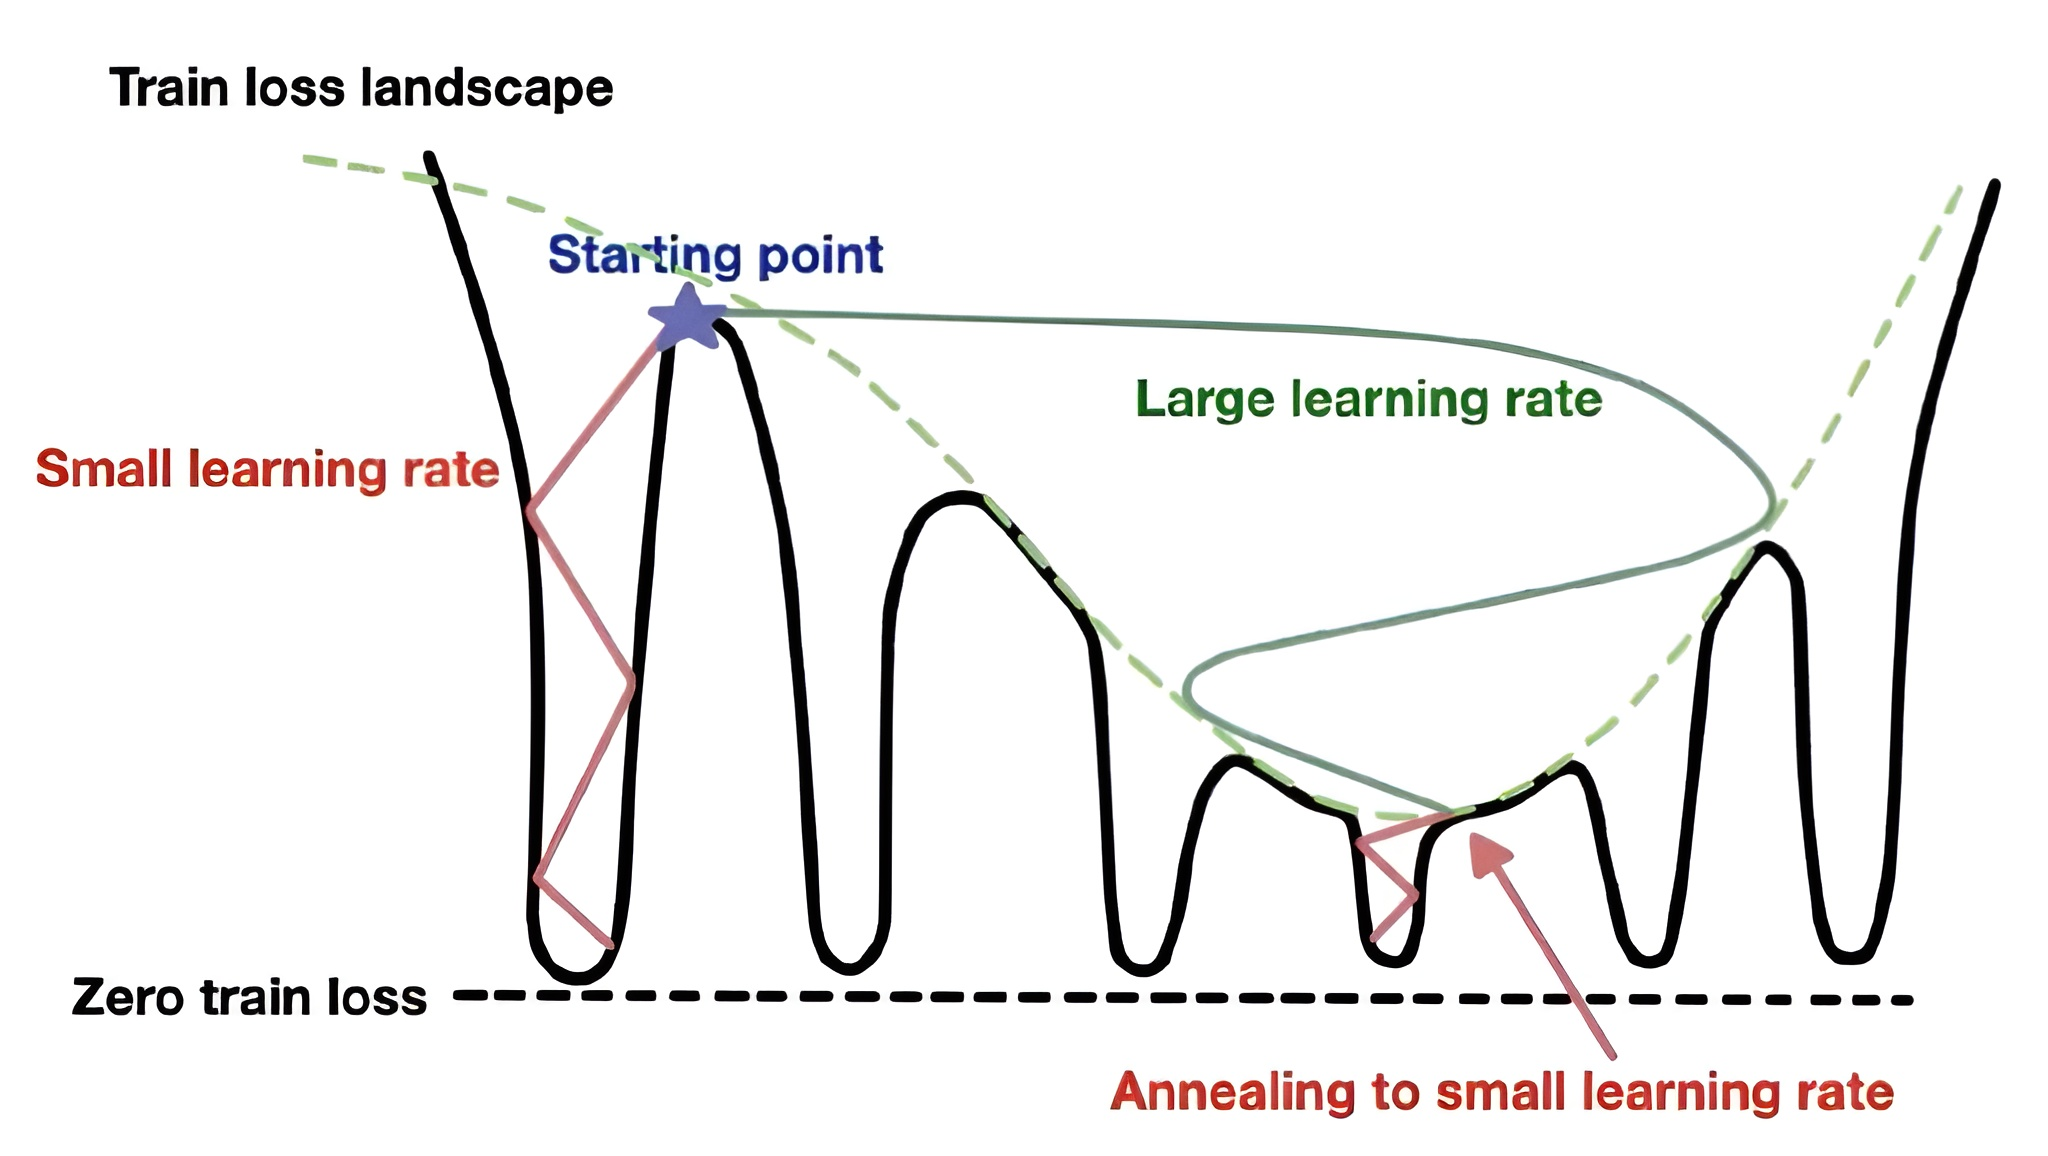

[Источник](https://speakerdeck.com/opentalks/opentalks-dot-ai-dmitrii-vietrov-fraktal-nost-funktsii-potier-effiekt-dvoinogho-spuska-i-stiepiennyie-zakony-v-ghlubinnom-obuchienii-fraghmienty-odnoi-mozaiki)

Тут мы видим именно описанную ситуацию, есть широкий минимум (зеленая пунктирная линия), в нем есть локальные минимумы, а есть глобальный (самый левый), который не принадлежит широкому. И тут же на картинке написан рецепт, как попасть в широкий минимум ([[6]](https://arxiv.org/pdf/2311.11303), [[7]](https://arxiv.org/abs/2410.22113)):

1) Начинаем обучение с большим learning rate. Он будет "проскакивать" все узкие минимумы, так как не сможет сойтись к ним, а вот в широком он застрянет

2) Потом уменьшаем learning rate, чтобы доучить модель. Из широкого минимума мы уже не сбежим и дойдем до хорошего локального минимума

Прием с изменением learning rate в процессе обучения хорошо известен и называется learning rate scheduling.

### Learning Rate Scheduling

Разберем самые популярные расписания для шага обучения

#### Linear Decay

Шаг обучения уменьшается линейно с каждой итерацией:
$$
\eta_t = \eta_0 \times (1 - \frac{t}{T}),
$$
где

$\eta_0$ &ndash; начальный шаг обучения;

$t$ &ndash; текущая итерация;

$T$ &ndash; общее число итераций.

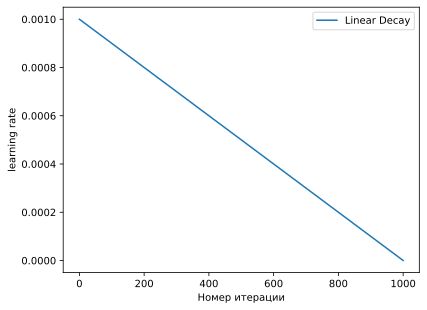

In [ ]:
T = 1000
t = np.arange(T+1)
base_lr = 1e-3
linear_weight = 1 - t / T
plt.plot(t, base_lr * linear_weight, label='Linear Decay')
plt.legend()
plt.xlabel('Номер итерации')
plt.ylabel('learning rate')
plt.show()

#### Exponential decay

Шаг обучения уменьшается экспоненциально:

$$ \eta_t = \eta_0 \times e^{-\lambda t},$$
где $\lambda$ &ndash; коэффициент убывания, регулирующий скорость спада.


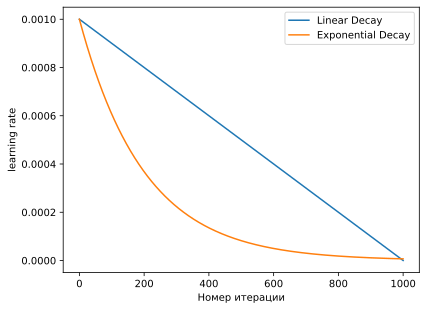

In [ ]:
lambda_ = 0.005
exp_weight = np.exp(-lambda_ * t)
plt.plot(t, base_lr * linear_weight, label='Linear Decay')
plt.plot(t, base_lr * exp_weight, label='Exponential Decay')
plt.legend()
plt.xlabel('Номер итерации')
plt.ylabel('learning rate')
plt.show()

#### Cyclical schedulers

Шаг обучения циклически изменяется между минимальным и максимальным значением, заданными заранее:

$$ \eta_t = \eta_{min} + (\eta_{max} - \eta_{min}) \times scale(t). $$

Популярным выбором такого расписания является `CosineAnnealing`:

$$ \eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})\left(1 + cos(\frac{T_{cur}}{T_{i}} \pi)\right), $$
где

$T_{cur}$ &ndash; количество обновлений lr с последнего рестарта ($T_{cur} = T_{i}$);

$T_{i}$ &ndash; количество шагов обновлений до рестарта.

Замечание. Обычно `CosineAnnealing` используется без рестартов и обновляется каждую итерацию обучения, то есть $T_{i}$ &ndash; общее количество итераций в обучении, $T_{cur}$ &ndash; номер текущей итерации обучения.

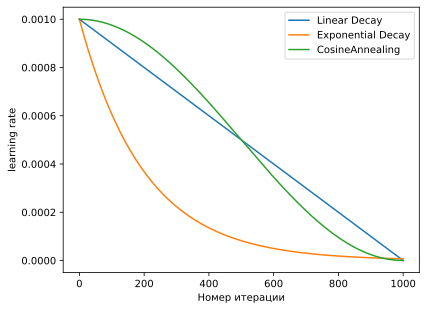

In [ ]:
lr_min = 0.0
cos_lr = lr_min + 0.5 * (base_lr - lr_min) * (1 + np.cos(t / T * np.pi))
plt.plot(t, base_lr * linear_weight, label='Linear Decay')
plt.plot(t, base_lr * exp_weight, label='Exponential Decay')
plt.plot(t, cos_lr, label='CosineAnnealing')
plt.legend()
plt.xlabel('Номер итерации')
plt.ylabel('learning rate')
plt.show()

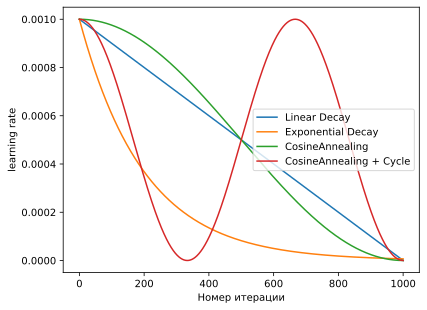

In [ ]:
lr_min = 0.0
cycle_cos_lr = lr_min + 0.5 * (base_lr - lr_min) * (1 + np.cos(3 * t / T * np.pi))
plt.plot(t, base_lr * linear_weight, label='Linear Decay')
plt.plot(t, base_lr * exp_weight, label='Exponential Decay')
plt.plot(t, cos_lr, label='CosineAnnealing')
plt.plot(t, cycle_cos_lr, label='CosineAnnealing + Cycle')
plt.legend()
plt.xlabel('Номер итерации')
plt.ylabel('learning rate')
plt.show()

#### Warmup schedulers

Часто в статьях по DL вы будете видеть расписания с warmup. Например, такой:

$$
\eta_t = \eta_0 \times min(1, \frac{t}{T}),
$$

Или его сочетание с любым другим scheduler-ом.

Большинство современных нейросетей учатся с помощью расписания `CosineAnnealing` + `Warmup`.

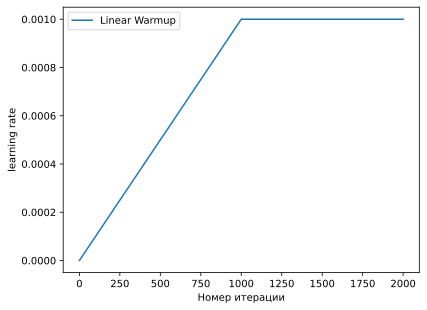

In [ ]:
T = 1000
t = np.arange(2 * T+1)
base_lr = 1e-3
linear_warmup = t / T
warmup_lr = np.minimum(base_lr, base_lr * linear_warmup)
plt.plot(t, warmup_lr, label='Linear Warmup')
plt.legend()
plt.xlabel('Номер итерации')
plt.ylabel('learning rate')
plt.show()

### Зачем нужен warmup?

Возникает очень логичный вопрос, а зачем нужен warmup, если мы только что рассуждали, что мы наоборот хотим большой learning rate, а с маленьким мы наоборот сойдемся в узкий минимум, и все будет плохо. Инженерный ответ на это простой &ndash; многие модели без warmup учатся хуже, а так как мы делаем мало шагов с маленьким lr, то в узкий минимум сойтись не успеем. Гораздо интереснее, почему без warmup модели часто учатся хуже.

Тут у сообщества есть несколько теорий:

1) Нас интересует не learning rate, а эффективный lr, то есть не само число, а то, насколько сильно мы можем уйти от точки, из которой делаем итерацию оптимизатора. На начальных итерациях градиенты большие, поэтому при большом lr мы сделаем слишком большой шаг, на более поздних градиенты больше, поэтому мы можем себе позволить использовать большое значение lr;

2) Адаптивные оптимизаторы используют для шага некоторые статистики, которые в первые итерации будут очень шумные (так как для их накопления использовалось мало данных), поэтому чтобы не уйти куда-то не туда из-за этого эффекта, предлагается на первых итерациях запретить параметрам уходить далеко от начальной точки и "прогреть" статистики;

3) Из теории оптимизации известно, что learning rate, при котором процесс оптимизации сходится, ограничен единицей, деленой на старшее собственное значение гессиана. В силу случайности инициализации нейронной сети мы можем попасть в точку, где это собственное значение будет большим, и тогда использование большого lr приведет к тому, что модель разойдется. Также можно показать, что у градиентных методов есть свойство самостабилизации &ndash; при корректном выборе lr, они умеют уходить из точек, где старшее собственное значение гессиана большое [[8]](https://arxiv.org/pdf/2406.09405).

4) Еще одно теоретическое обоснование &ndash; в условиях обобщенной гладкости (которая считается более близкой к DL) при доказательстве сходимости натуральным образом получается learning rate warmup [[9]](https://arxiv.org/pdf/2602.05813).

Как мы видим, вариантов объяснения этого эффекта много. Но нам нужно понимать только то, что этот прием работает и ничему не противоречит.

### Weight decay

Немного поговорим про `weight decay`. Запишем итерацию градиентного спуска с L2 регуляризацией:

$$
w^{i+1} = w^{i} - \epsilon_{i}(\nabla_{w}\mathfrak{L}(w) + \lambda w^{i})
$$

Немного преобразуем итерацию:

$$
w^{i+1} = \mathbf{(1 - \lambda\epsilon_i)}w^{i} - \epsilon_{i}\nabla_{w}\mathfrak{L}
$$

Обозначим $\lambda' = \lambda\epsilon_i$ и получим:

$$
w^{i+1} = \mathbf{(1 - \lambda')}w^{i} - \epsilon_{i}\nabla_{w}\mathfrak{L}
$$

Вообще говоря, именно такая схема обновлений называется `weight decay`, а не просто L2 регуляризация. Зачем это может быть нужно? Такая схема буквально уменьшает веса $w$, а уменьшение весов приводит к тому, что градиенты относительно размера весов становятся больше. А это значит, что мы увеличиваем эффективный learning rate! Более того, у нас же стохастический градиент, и мы уже знаем, что шум от стохастики является хорошим регуляризатором в DL, а `weight decay` также масштабирует уровень шума относительно весов модели, делая такую регуляризацию более эффективной. Есть работа, показывающая, что `weight decay` отвечает именно за стабильную регуляризацию от шума.


### AdamW

Вернемся в 2017, Adam себя чувствовал прекрасно для RNN, трансформеров, но вот для CNN SGD+momentum оставался лучшим выбором. И вот люди начали подозревать, что проблема в том, что `weight decay` для SGD эквивалентен L2 регуляризации, а вот для адаптивных методов нет. Интуиция здесь следующая: когда Adam используется для оптимизации модели с L2 регуляризацией, веса, которые во время обучения имеют большие градиенты, не регуляризуются так сильно, как это было бы при использовании `weight_decay`, поскольку градиент регуляризатора масштабируется с учетом градиентов функции потерь. Можно даже показать формальное утверждение, что в случае Adam `weight decay` не эквивалентен L2 регуляризации. А теперь подумаем, что это значит. Мы неправильно добавили регуляризатор, который отвечает за большой эффективный learning rate, а большой эффективный learning rate отвечает как раз за то, что минимум, в который мы попадем будет отвечать за генерализацию.

Как решить эту проблему? Сделаем AdamW ([Loshchilov & Hutter, 2017](https://arxiv.org/abs/1711.05101), примерно 38 тысяч цитирований) &ndash; Adam + правильный `weight decay` ():

\begin{align}
&m^{i}_{j} = \beta_{1}m^{i-1}_{j} + (1 - \beta_{1})g^{i}_{j},\\
&v^{i}_{j} = \beta_{2}v^{i-1}_{j} + (1 - \beta_{2})(g^{i}_{j})^2,\\
&\hat{m}^{i}_{j} = \frac{m^{i}_{j}}{1 - \beta_{1}^{i}},\; \hat{v}^{i}_{j} = \frac{v^{i}_{j}}{1 - \beta_{2}^{i}},\; \Delta^{i}_{j} = \frac{\hat{m}^{i}_{j}}{\sqrt{\hat{v}^{i}_{j}} + \epsilon},\\
&w^{i+1} = w^{i} - \epsilon_{i}(\Delta^{i} + \mathbf{\lambda w^{i}}).
\end{align}

## Современные результаты в оптимизаци в DL

### AdEMAMix

Вспомним, как работает Adam. Он использует экспоненциальное скользящее среднее (EMA) для оценки первого момента градиента:
$$m_t = \beta_1 m_{t-1} + (1-\beta_1)g_t.$$

Параметр $\beta_1$ определяет, как быстро оптимизатор «забывает» старую информацию. Обычно $\beta_1 \approx 0.9$. Проблема в том, что один параметр заставляет выбирать компромисс между фокусом на свежие данные (маленькая $\beta$) и использованием длинной истории (большая $\beta$).

В 2024 году была предложена простая, но эффективная модификация &ndash; `AdEMAMix` (Adaptive EMA Mixture) ([[11]](https://arxiv.org/abs/2409.03137)). Идея состоит в том, чтобы не выбирать компромисс, а поддерживать два «пути»: быстрый и медленный.

1. **Fast EMA:** $m_{fast, t} = \beta_{fast} m_{fast, t-1} + (1-\beta_{fast})g_t$ (быстро забывает, $\beta \approx 0.9$)
2. **Slow EMA:** $m_{slow, t} = \beta_{slow} m_{slow, t-1} + (1-\beta_{slow})g_t$ (медленно забывает, $\beta \approx 0.999$)
3. **Mixture:** Итоговый момент для шага &ndash; это взвешенная сумма:
$$ m_t = \alpha m_{slow, t} + m_{fast, t}. $$

Остальная часть (адаптивный шаг через RMSProp) остается как в AdamW. Эта небольшая добавка позволяет оптимизатору использовать преимущества обоих режимов, что на практике привело к заметному улучшению качества обучения больших языковых моделей и трансформеров, но данная модификация приводит к большим расходам на память. Типичное значение $\alpha \in [2, 10]$.


### Constant Learning Rate with Cooldown


Как было уже сказано, большинство современных нейросетей учатся с помощью расписания `CosineAnnealing` + `Warmup`. Так сложилось исторически. Какая с ним есть проблема? Как мы уже знаем, чтобы попасть в действительно хороший минимум, мы должны уменьшать learning rate. А что если мы хотим замерить перфоманс модели в середине обучения? Мы должны начать уменьшать learning rate. Но у `CosineAnnealing` такой опции просто нет: финальный learning rate зависит от того, сколько итераций мы учимся. И тут оказывается, что максимально простая идея &ndash; сперва повысим lr, потом будем его держать константным, потом понизим &ndash; работает не хуже ([[12]]((https://arxiv.org/abs/2405.18392))).

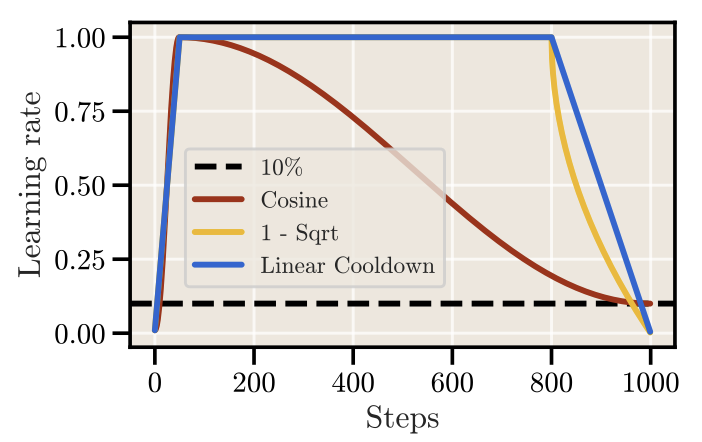

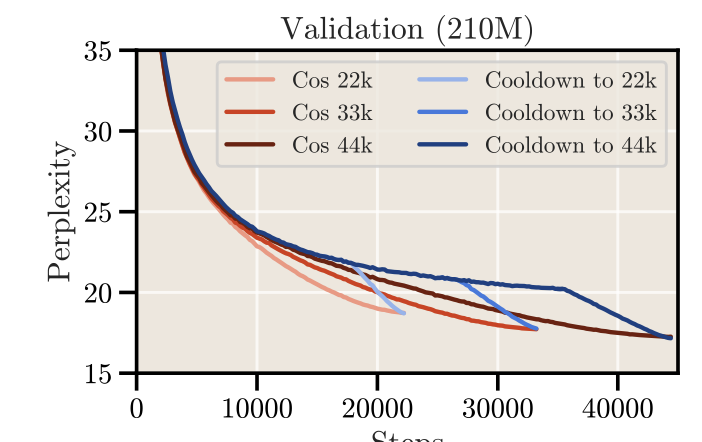

### Schedule-Free Optimizer

На секунду залезем в мир теории оптимизации. Оттуда известно, что последняя точка, полученная SGD за T итераций, будет хуже с точки зрения оптимизации, чем усреднение точек всей траектории. Однако, на практике мы имеем ровно обратный эффект.

Было показано, что learning rate schedulers позволяют решить эту проблему с одной стороны. Однако, как мы уже поняли, у расписаний есть один минус &ndash; они требуют знать, сколько итераций мы собираемся обучаться. И даже Cooldown не решает эту проблему: для замера качества в середине обучения мы должны поучиться какое-то время со снижением lr. И люди решили зайти с другой стороны: если lr schedulers улучшают оптимизацию с точки зрения последней точки, то, возможно, интеграция умного усреднения весов модели поможет избавиться от необходимости использовать расписания?

Так появился Schedule-Free Optimizer ([[13]](https://arxiv.org/abs/2405.15682)). Его SGD+momentum версия выглядит следующим образом:

\begin{align}
& y_t = (1 - \beta) z_t + \beta x_t,\\
& z_{t+1} = z_t - \eta \nabla f(y_t, \xi_t),\\
& x_{t+1} = (1 - c_{t+1})x_t - c_{t+1}z_{t+1}.
\end{align}

Такая интеграция усреднения весов модели в процесс оптимизации с интеграцией AdamW шага оказалась очень хорошим оптимизатором, который меньше зависит от learning rate schedulers и даже выиграл конкурс AlgoPerf 2024. Однако, все еще их использование способно улучшать качество обучения модели.

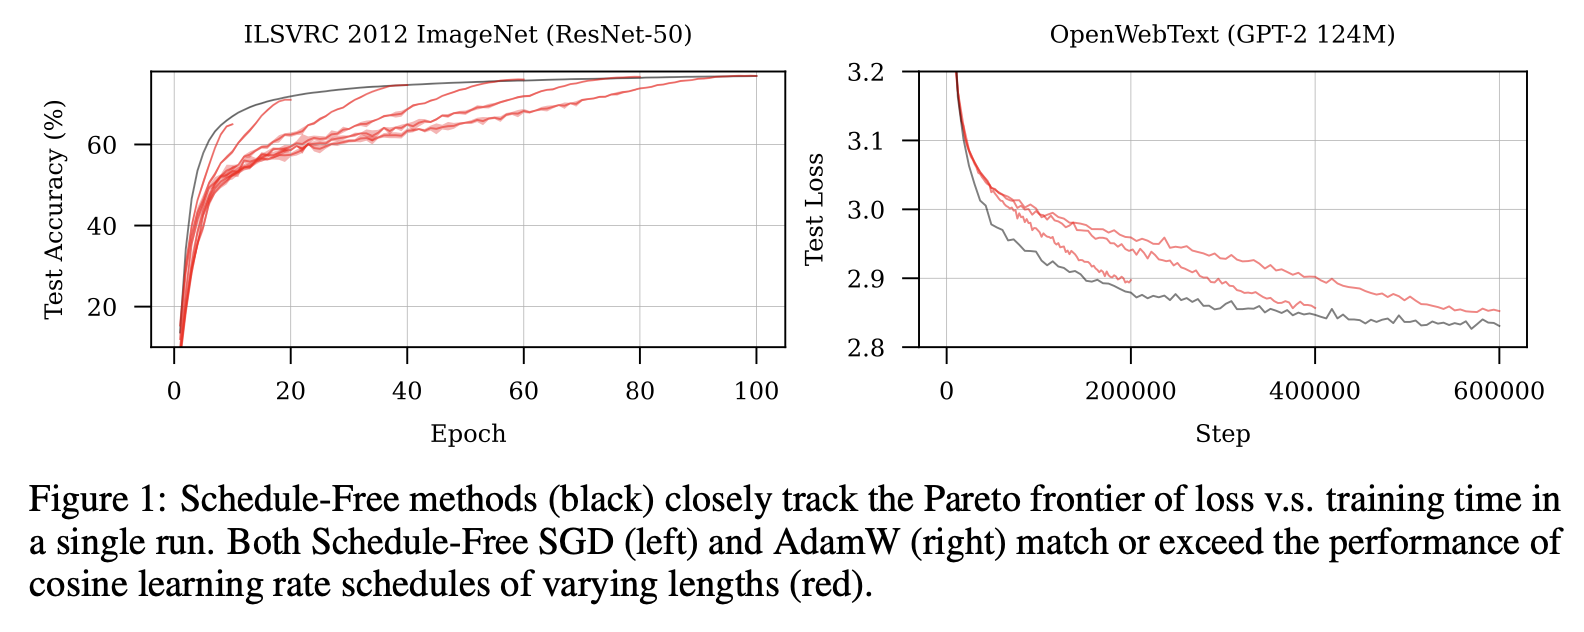

### Sign is All You Need for Efficient Optimization

Представим ситуацию. Ваша нейронка учится с очень большим размером батча, настолько большим, что он не вмещается в видеокарточку. А у вас их много. Тогда можно раскидать кусочки батча на разные видеокарты, считать градиенты по кускам и усреднять их. Возникает проблема &ndash; вы должны передавать ваши градиенты по сети. А это медленно. Оказывается, что можно передавать не весь градиент, а только его знак, а вместо усреднения использовать голосование большинством для выбора знака. Мы получили сжатие в 32 (или 16 в зависимости от точности) раза! Круто? Круто. А работать то это будет? Да, и не только в распределенном сэтапе. Даже просто обучать модельку, используя только знак градиента можно. Такой метод называется SignSGD ([[14]](https://arxiv.org/abs/1802.04434)). В него можно добавить инерцию и получить Signum, можно добавить два моментума и получить Lion ([[15]](https://arxiv.org/abs/2302.06675)).

Зачем знать об этих методах? Использование только знака градиента оказывается удачной регуляризацией, и позволяет иногда нейронкам лучше учиться.

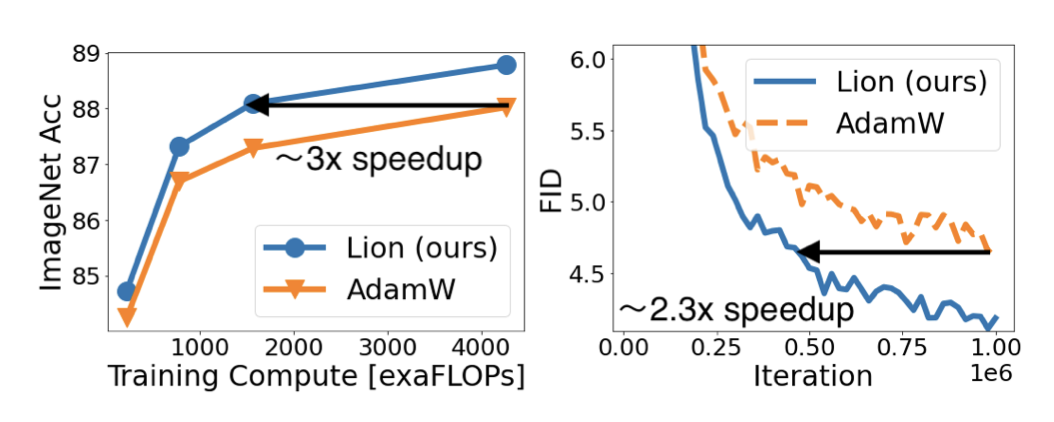

### Second-Order Methods Strike Back

Не будем вдаваться в подробности, как работает этот метод, а только опишем идею. Основная цель этого параграфа &ndash; показать, что методы второго порядка могут работать в DL, и, возможно, Adam и его вариации не навсегда с нами

Метод Ньютона сходится очень быстро из-за использования информации о гессиане, однако, он вычислительно дорог. Возникает идея попробовать как-то аппроксимировать гессиан, используя только информацию о градиентах. Такие методы называются квазиньютоновские. Некоторое время назад был разработан метод &ndash; Shampoo ([[16]](https://arxiv.org/abs/1802.09568)), который хорошо показал себя с точки зрения качества в DL. Однако, он был вычислительно затратен, потому что требовал регулярно считать SVD для построения приближения гессиана. И пропуск пересчета вел к тому, что метод переставал работать, так как информация, которая обновляется на каждой итерации начинала сильно расходиться с информацией, которая обновлялась редко. Была предложена идея добавить связь с прошлым для регулярно обновляемых параметров прямо так, как это сделано в Adam. Получившийся метод &ndash; SOAP ([[17]](https://arxiv.org/abs/2409.11321)) &ndash; показал себя хорошо во многих задачах, при этом не увеличивая на порядки время обучения.

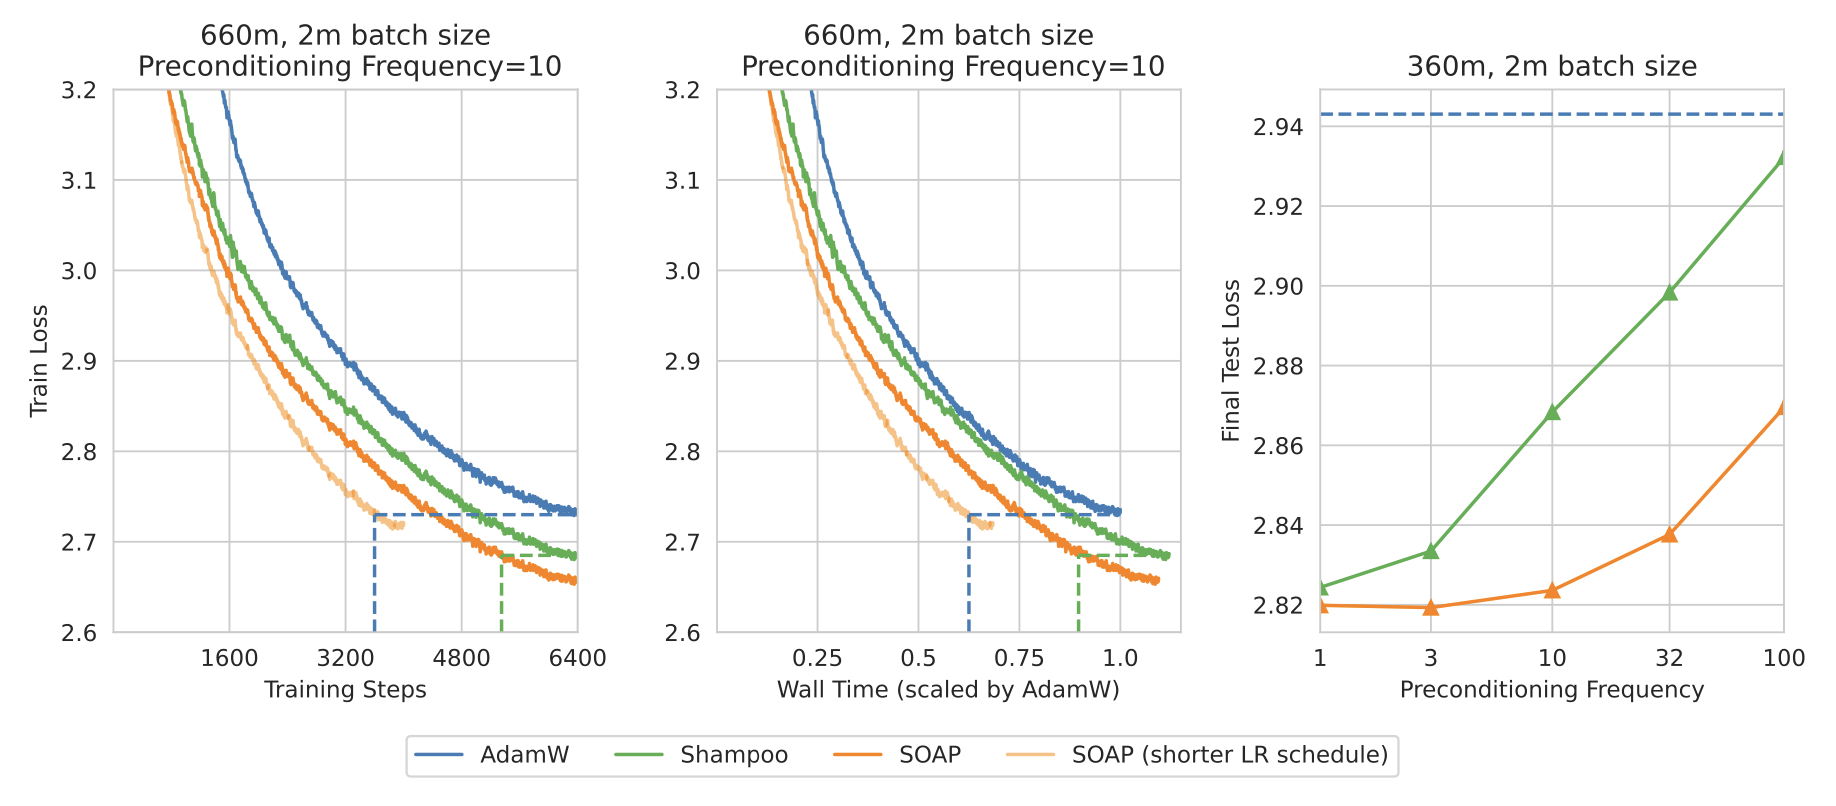

### Muon: MomentUm Orthogonalized by Newton-Schultz

Muon &ndash; совсем свежий и нашумевший оптимизатор, который изначально появился как "твит в X", но быстро показал SOTA результаты при обучении трансформеров, обогнав AdamW ([[18]](https://kellerjordan.github.io/posts/muon/)). Чтобы понять, как он работает, нужно взглянуть на оптимизацию через призму **Linear Minimization Oracle (LMO)**.

**1. Оптимизация как поиск в ограниченной области**

Многие оптимизаторы можно представить как решение задачи: «Найти шаг $\Delta w$, который максимально уменьшает линейную аппроксимацию функции потерь $g^T \Delta w$, при условии, что размер шага ограничен $||\Delta w|| \le \eta$».
$$ w_{t+1} = \text{argmin}_{w \in \mathbb{R}^d, \|w - w_t\| \le \eta} \langle \nabla \mathfrak{L}(w_t), w - w_t \rangle.$$
То, какой именно оптимизатор мы получим, зависит от выбора нормы $\|\cdot\|$:
* Если взять **L2-норму** (евклидову), то наискорейший спуск будет направлен прямо против градиента. Мы получаем классический **SGD**.
* Если взять **L-infinity норму** ($L_\infty$, максимум по модулю), то мы разрешаем каждому параметру сдвинуться на $\eta$ независимо. Оптимальное решение &ndash; сдвинуться на $\eta \cdot \text{sign}(g)$. Мы получаем **SignSGD**.

**2. Матрицы и Спектральный SGD**

В глубоком обучении мы обновляем не абстрактные векторы, а матрицы весов $W \in \mathbb{R}^{N \times M}$. Для матриц естественным обобщением $L_2$ нормы для векторов является не Фробениусова норма (которая просто выпрямляет матрицу в вектор), а **Спектральная норма** (наибольшее сингулярное число $\sigma_{max}(W)$).
Если мы поставим задачу оптимизации с ограничением на спектральную норму шага, мы получим **Spectral SGD**. Его шаг обновления выглядит так: если SVD разложение градиента это $\nabla \mathfrak{L} = U \Sigma V^T$, то шаг обновления:
$$ \Delta W \propto U V^T.$$
То есть мы заменяем все сингулярные числа градиента на единицы, оставляя только направления (аналогично тому, как SignSGD заменяет величины компонент на единицы).

**3. Проблема скорости и Newton-Schultz**

Честный расчет SVD ($O(N^3)$) на каждом шаге убил бы обучение. Здесь на сцену выходит метод Ньютона-Шульца. Это итеративный алгоритм, который позволяет найти полярное разложение матрицы (превратить её в ортогональную), используя только матричные умножения.

* **Суть метода:** Представьте, что у матрицы $G$ есть сингулярные числа $\sigma_i$. Наша цель &ndash; превратить их все в $1$. Мы ищем такое преобразование $X_{k+1} = f(X_k)$, которое бы отображало сингулярные числа $\sigma \to 1$.
* **Классическая итерация (кубическая):** $X_{k+1} = \frac{1}{2}X_k (3I - X_k^T X_k)$.
Если разложить это по сингулярным числам, то $\sigma_{new} = \frac{1}{2}\sigma(3-\sigma^2)$. График этой функции похож на перевернутую параболу, которая "выталкивает" значения к 1.


Классический Ньютон-Шульц сходится, но требует много итераций. В Muon используется модифицированная схема, использующая полином **5-й степени**.
Идея в том, чтобы за одну операцию обновления сделать больше вычислений (что дешево на GPU) и тем самым сократить число шагов (что дорого из-за чтения памяти).

Итерация в Muon выглядит так (для матрицы $X$, которую мы хотим ортогонализовать):
1. Считаем $A = X^T X$ (или $XX^T$, если матрица широкая).
2. Обновляем $X \leftarrow X (\alpha I + \beta A + \gamma A^2)$.

Поскольку $A$ уже содержит $X^2$ (в смысле степеней), то итоговое выражение содержит $X^5$. Коэффициенты $\alpha, \beta, \gamma$ подбираются численно так, чтобы этот полином максимально быстро "сплющивал" спектр сингулярных чисел в диапазон $[0.7, 1.3]$ (или близко к 1). Оказывается, для обучения нейросетей идеальная ортогональность не нужна, достаточно, чтобы спектр был ограничен. Обычно хватает 5 итераций такого алгоритма.


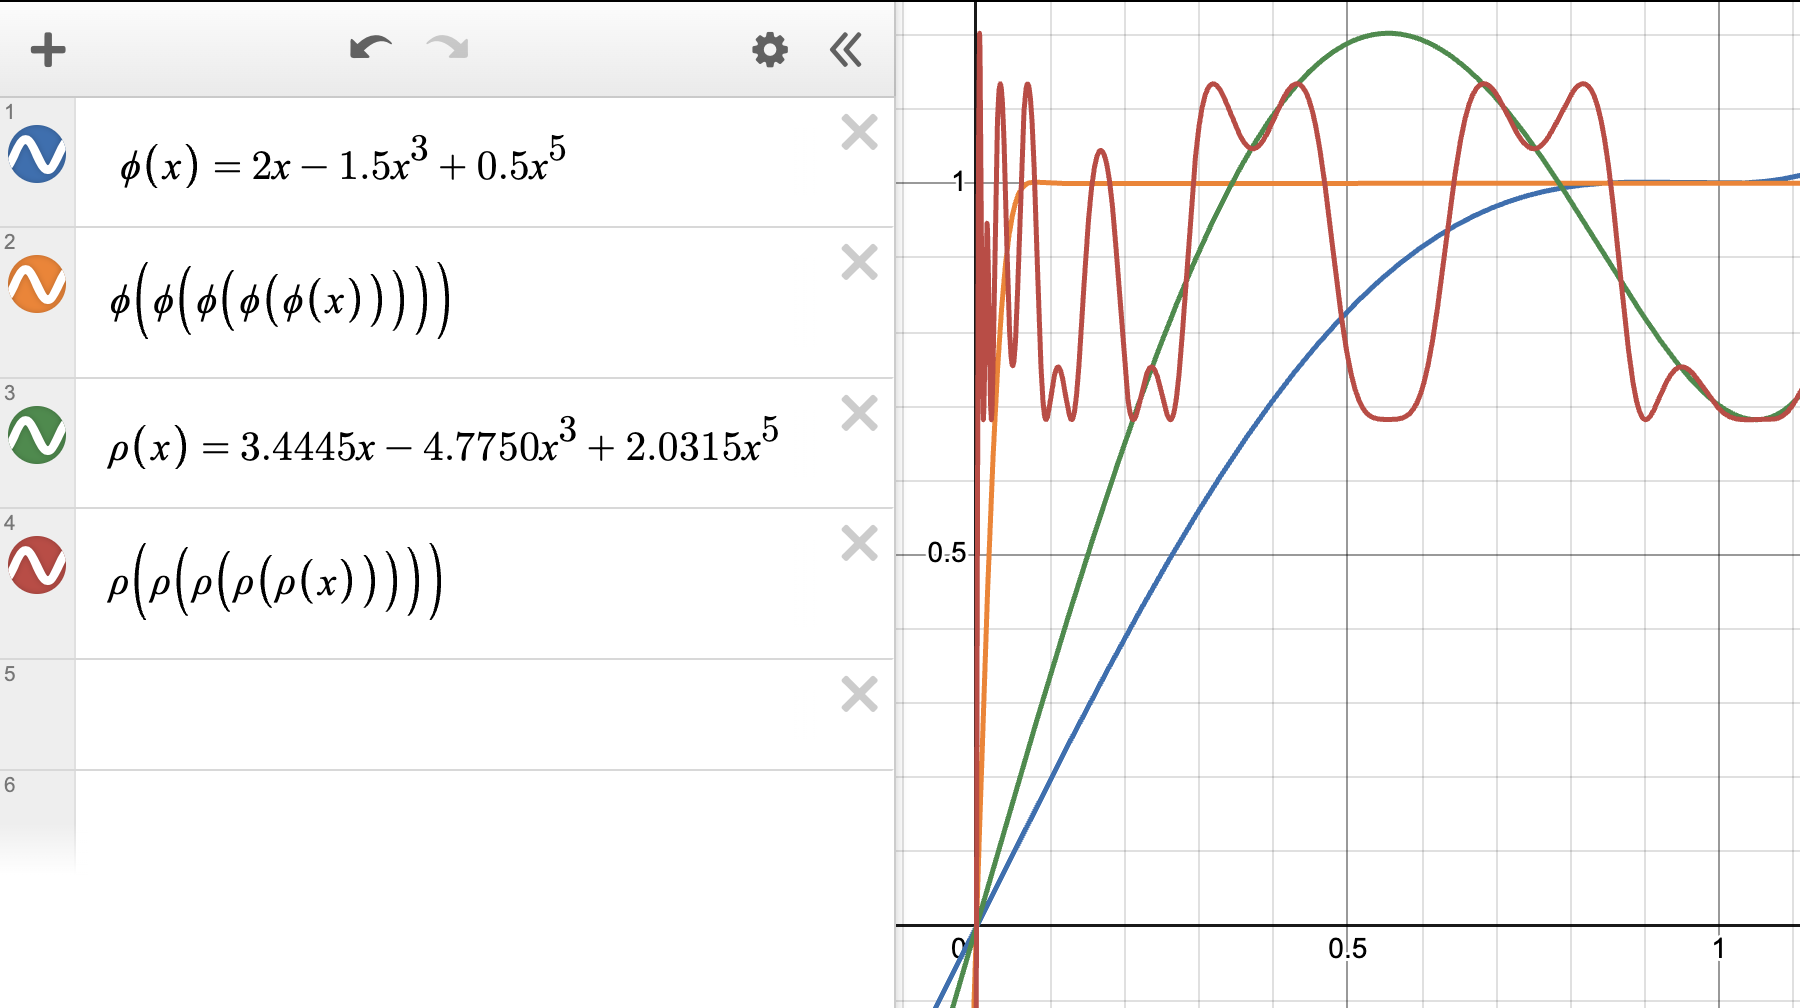


**4. Алгоритм Muon**

Muon объединяет идею Спектрального SGD с моментумом (инерцией), как в SGD+Momentum или Adam.
1. Считаем импульс (как обычно): $$M_t = \mu M_{t-1} + \nabla \mathfrak{L}_t.$$
2. Ортогонализуем импульс с помощью итераций Ньютона-Шульца: $$O_t = \text{NewtonSchultz}(M_t).$$
3. Делаем шаг: $$W_{t+1} = W_t - \eta \cdot O_t.$$

**Почему это работает? (Гипотезы)**
1. Как и Adam, Muon игнорирует масштаб градиента по осям, но делает это с учетом корреляций внутри матрицы, а не поэлементно.
2. Он принудительно обновляет все «латентные направления» матрицы весов с примерно одинаковой скоростью, не давая доминирующим направлениям забирать всё внимание оптимизатора.
3. Это особенно полезно для больших слоев в трансформерах, где спектр градиентов часто очень перекошен.

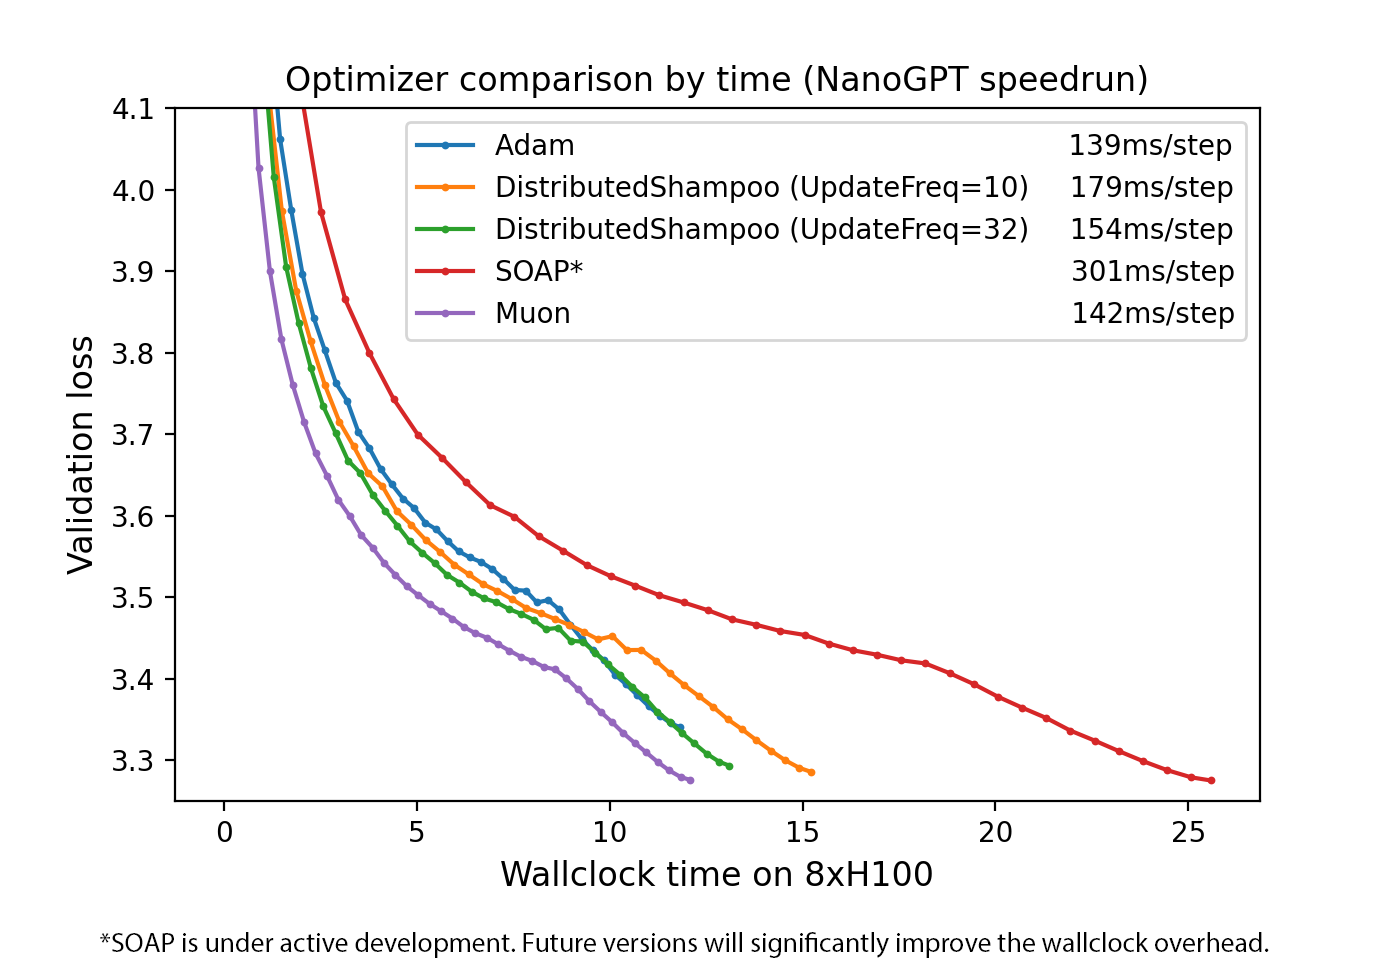

### А какой оптимизатор лучше использовать?

Однозначного ответа на этот вопрос нет. В большинстве случаев достаточно использовать AdamW + CosineWarmupAnnealing scheduling. В данный момент Muon является основным конкурентом данной паре, но при этом часть сообщества считает AdEMAMix более надежным результатом. Однако в некоторых задачах может оказаться так, что какой-то из перечисленных выше (или даже других) оптимизаторов будет работать лучше. Когда вы работаете над задачей не стоит бежать сразу перебирать все подряд оптимизаторы, но если у вас откуда-то есть понимание, что вы плохо оптимизировали вашу нейронку, или уже перепробовали все остальное, то попробовать Lion/Signum/SOAP/Другие оптимизаторы/Другие Scheduling &ndash; хорошая идея.



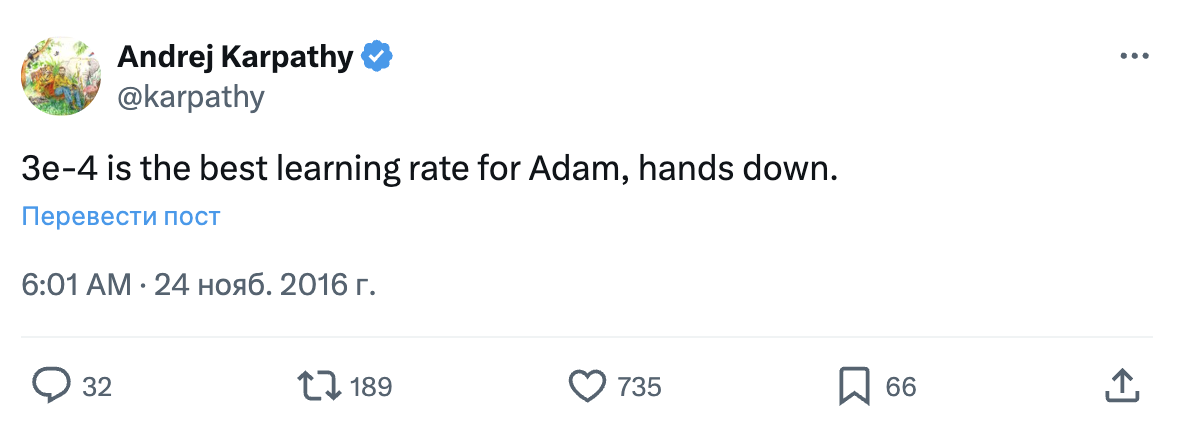